In [2]:
from __future__ import division
from math import *
import numpy as np
import sys
import os
from matplotlib.ticker import LogFormatter
from matplotlib.ticker import LogFormatterExponent
from matplotlib.ticker import LogFormatterSciNotation

import pandas as pd
import numpy as np
import matplotlib, os
import matplotlib.pyplot as plt
# Matplotlib configuration
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True
matplotlib.style.use('classic')
plt.rcParams['xtick.direction']     = 'in'
plt.rcParams['ytick.direction']     = 'in'
plt.rcParams['xtick.top']           = True
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.right']         = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
import matplotlib.cm as cm

from matplotlib import pyplot
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True
matplotlib.rc('text', usetex = True)
matplotlib.rc('font', **{'family' : "sans-serif"})
params= {'text.latex.preamble' : [r'\usepackage{amssymb}']}
pyplot.rcParams.update(params)

from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from matplotlib.ticker import AutoMinorLocator
from matplotlib.ticker import FuncFormatter
from scipy.interpolate import griddata
from scipy.interpolate import interp1d

import sys
sys.path.append("/Users/oozdal/packages/ma5-histo")
sys.path.append("/Users/oozdal/packages/ma5_expert")

import src.SafReader as sr
from CutFlowReader import Collection 

In [3]:
def df(fileLoc):
    data = sr.read(fileLoc=fileLoc)
    floatCols=['binMin', 'binMax', 'value']
    data[floatCols]  = data[floatCols].apply(pd.to_numeric, errors='coerce')
    data["bin"]      = (data.binMin+data.binMax)/2
    data             = data[data.binMax != np.inf]
    data             = data[data.binMin != -1*np.inf]
    data["binlabel"] = (data.binMin+data.binMax)/2
    return data

In [234]:
def unc(observable, Nevt):
    return np.sqrt((1-observable**2)/Nevt)

In [228]:
lumi=3000.

# Standard Model (SM)

In [201]:
AC_data = '/Users/oozdal/projects/SSM_WpZp/AC_data'


SM = Collection(collection_path    = AC_data+'/SMlepneut_LO/MadAnalysis5job_0/Cutflows',
                    xsection       = (1.044819e+03*15000000 + 5.780900e+00*1000000 + 5.781400e+00*1000000 + 5.780500e+00*1000000 + 5.118800e-01*1000000)/(19000000), 
                    lumi           = 3000.)

#SM = Collection(collection_path    = AC_data+'/SMlepneut_LO/MadAnalysis5job_0/Cutflows',
#                    saf_file       = AC_data+'/SMlepneut_LO/SMlepneut_LO.saf', 
#                    lumi           = 3000.)

#SM_2 = Collection(collection_path    = AC_data+'/SMlepneut_LO_2/MadAnalysis5job_0/Cutflows',
#                    saf_file       = AC_data+'/SMlepneut_LO_2/SMlepneut_LO_2.saf', 
#                    lumi           = 3000.)

#SM_totxsec = (SM.xsec*5000000 + SM_2.xsec*10000000) / (5000000 + 10000000)
#SM_sumw   = SM['SR_Lepton'][0].sumw + SM_2['SR_Lepton'][0].sumw

SM_totxsec = SM.xsec
SM_sumw    = SM['SR_Lepton'][0].sumw

print(SM_sumw)
print(SM.xsec)

13.30909
825.796825263


In [202]:
ACdata = '/Users/oozdal/projects/SSM_WpZp/AC_data/'
all_filenames = ["SMlepneut_LO_new4.csv"]    # SMlepneut_LO_new4.csv
SM_df = pd.concat([pd.read_csv(ACdata+f, header=0, sep=",") for f in all_filenames ])
SM_df.columns = ["MET", "MTMiss", "Eta", "Lepton_PT", "Lepton_ID", "BoostedLep_Eta", "EvWeight"]
print(min(SM_df["MTMiss"]))
print(max(SM_df["MTMiss"]))
SSM_df.head(5)

50.0
4999.97


,MET,MTMiss,Eta,Lepton_PT,Lepton_ID,BoostedLep_Eta,EvWeight
0,3314.80,6629.60,-0.126301,3314.80,-13,-0.063150,0.00006
1,2353.57,4707.14,0.390488,2353.57,-13,0.195244,0.00006
2,3145.41,6290.83,0.207652,3145.41,-13,0.103826,0.00006
3,2020.84,4041.69,1.071280,2020.84,-11,0.535639,0.00006
4,3201.03,6402.06,-0.266577,3201.03,-13,-0.133289,0.00006


In [203]:
# Applt Eta < 2.5
SM_df = SM_df[:][(abs(SM_df["Eta"])<=2.5)]    # Eta(lepton) < 2.5 

# Apply PT > 25 GeV
SM_df = SM_df[:][(SM_df["Lepton_PT"]>=25)]

SM_df = SM_df[:][(SM_df["MTMiss"]>500) ] # & (SM_df["MET"]>0) & (SM_df["Lepton_PT"]>0)

SM_df.head(5)

,MET,MTMiss,Eta,Lepton_PT,Lepton_ID,BoostedLep_Eta,EvWeight
2000001,257.982,515.964,0.985148,257.982,-11,0.492574,0.40001
2000002,253.342,506.684,-0.764147,253.342,-13,-0.382074,0.40001
2000004,297.550,595.101,-1.612770,297.550,-11,-0.806386,0.40001
2000011,255.039,510.077,-1.263430,255.039,-13,-0.631714,0.40001
2000012,297.348,594.696,1.320910,297.348,-13,0.660456,0.40001


# True AC Components for the Standard Model

In [208]:
SM_AC_pos = SM_df[ (SM_df["Lepton_ID"] < 0.) ]      # Positively charged leptons (-11,-13)
SM_AC_neg = SM_df[ (SM_df["Lepton_ID"] > 0.) ]      # Negatively charged leptons (11,13)

BinNumber = 26
BinFirst  = 500.
BinLast   = 7000.

StepSize = (BinLast - BinFirst)/BinNumber
bins = []
bins.append(BinFirst)

for i in range(BinNumber): 
    BinFirst = BinFirst + StepSize
    bins.append(BinFirst)

TotEvWeight_LepPos_List1 = []
TotEvWeight_LepNeg_List1 = []

TotEvWeight_LepPos_List2 = []
TotEvWeight_LepNeg_List2 = []

i=0
for i in range(len(bins)-1):
    Box_LepPos = SM_AC_pos[:][ (SM_AC_pos["MTMiss"]>bins[i]) & (SM_AC_pos["MTMiss"]<=bins[i+1]) ]
    TotEvWeight_LepPos = len(Box_LepPos["EvWeight"])
    TotEvWeight_LepPos_List1.append(TotEvWeight_LepPos)
    TotEvWeight_LepPos = sum(Box_LepPos["EvWeight"])
    TotEvWeight_LepPos_List2.append(TotEvWeight_LepPos)
       
    Box_LepNeg = SM_AC_neg[:][ (SM_AC_neg["MTMiss"]>bins[i]) & (SM_AC_neg["MTMiss"]<=bins[i+1]) ]
    TotEvWeight_LepNeg = len(Box_LepNeg["EvWeight"])
    TotEvWeight_LepNeg_List1.append(TotEvWeight_LepNeg)
    TotEvWeight_LepNeg = sum(Box_LepNeg["EvWeight"])
    TotEvWeight_LepNeg_List2.append(TotEvWeight_LepNeg)       
    
TotEvWeight_LepPos_Arr1 = np.array(TotEvWeight_LepPos_List1)
TotEvWeight_LepNeg_Arr1 = np.array(TotEvWeight_LepNeg_List1)

TotEvWeight_LepPos_Arr2 = np.array(TotEvWeight_LepPos_List2)
TotEvWeight_LepNeg_Arr2 = np.array(TotEvWeight_LepNeg_List2)

AC_num = TotEvWeight_LepPos_Arr1 - TotEvWeight_LepNeg_Arr1
AC_den = TotEvWeight_LepPos_Arr1 + TotEvWeight_LepNeg_Arr1

AC_SM     = AC_num/np.where(AC_den==0,1e10,AC_den)
print(AC_SM)

SM_totsumw = sum(TotEvWeight_LepPos_Arr2)+sum(TotEvWeight_LepNeg_Arr2)

#Number of Events
NumofEvents_LepPos_SM = TotEvWeight_LepPos_Arr2*lumi*SM_totxsec*1000/SM_totsumw
NumofEvents_LepNeg_SM = TotEvWeight_LepNeg_Arr2*lumi*SM_totxsec*1000/SM_totsumw

[0.33377494 0.38396484 0.42884452 0.46992727 0.50531964 0.53691906
 0.56458202 0.58849075 0.60837384 0.63328531 0.64960009 0.66265541
 0.68218255 0.68733241 0.70433677 0.71249246 0.71804293 0.74088292
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


# Sequential Standard Model

In [216]:
AC_data = '/Users/oozdal/projects/SSM_WpZp/AC_data'

SSM = Collection(collection_path   = AC_data+'/SeqSMlepneut_LO/MadAnalysis5job_0/Cutflows',
                    saf_file       = AC_data+'/SeqSMlepneut_LO/SeqSMlepneut_LO.saf',
                    lumi           = 3000.)

SSM_2 = Collection(collection_path = AC_data+'/SeqSMlepneut_LO_2/MadAnalysis5job_0/Cutflows',
                    saf_file       = AC_data+'/SeqSMlepneut_LO_2/SeqSMlepneut_LO_2.saf',
                    lumi           = 3000.)

SSM_3 = Collection(collection_path = AC_data+'/SeqSMlepneut_LO_3/MadAnalysis5job_0/Cutflows',
                    saf_file       = AC_data+'/SeqSMlepneut_LO_3/SeqSMlepneut_LO_3.saf',
                    lumi           = 3000.)

SSM_totxsec = (SSM.xsec*5000000 + SSM_2.xsec*6000000 + SSM_3.xsec*5000000) / (5000000 + 6000000 + 5000000)
SSM_sumw   = SSM['SR_Lepton'][0].sumw + SSM_2['SR_Lepton'][0].sumw + SSM_3['SR_Lepton'][0].sumw

print(SSM_sumw)
print(SSM_totxsec)

1234758.3693
0.07717239808


In [217]:
ACdata = '/Users/oozdal/projects/SSM_WpZp/AC_data/'
all_filenames = ["SeqSMlepneut_LO.csv","SeqSMlepneut_LO_2.csv","SeqSMlepneut_LO_3.csv"]
SSM_df = pd.concat([pd.read_csv(ACdata+f, header=0, sep=",") for f in all_filenames ])
SSM_df.columns = ["MET", "MTMiss", "Eta", "Lepton_PT", "Lepton_ID", "BoostedLep_Eta", "EvWeight"]
print(min(SSM_df["MTMiss"]))
print(max(SSM_df["MTMiss"]))
SSM_df.head(5)

500.0
6999.99


,MET,MTMiss,Eta,Lepton_PT,Lepton_ID,BoostedLep_Eta,EvWeight
0,3314.80,6629.60,-0.126301,3314.80,-13,-0.063150,0.00006
1,2353.57,4707.14,0.390488,2353.57,-13,0.195244,0.00006
2,3145.41,6290.83,0.207652,3145.41,-13,0.103826,0.00006
3,2020.84,4041.69,1.071280,2020.84,-11,0.535639,0.00006
4,3201.03,6402.06,-0.266577,3201.03,-13,-0.133289,0.00006


Let's apply some bounds

In [218]:
# Applt Eta < 2.5
SSM_df = SSM_df[:][(abs(SSM_df["Eta"])<=2.5)]    # Eta(lepton) < 2.5 

# Apply PT > 25 GeV
SSM_df = SSM_df[:][(SSM_df["Lepton_PT"]>=25)]

SSM_df = SSM_df[:][(SSM_df["MTMiss"]>500)] # & (SSM_df["MET"]>1000) & (SSM_df["Lepton_PT"]>1000) 

# True AC Components for Sequential Standard Model

In [219]:
SSM_AC_pos = SSM_df[ (SSM_df["Lepton_ID"] < 0.) ]  # Positively charged leptons (-11,-13)
SSM_AC_neg = SSM_df[ (SSM_df["Lepton_ID"] > 0.) ]  # Negatively charged leptons (11,13)

BinNumber = 26
BinFirst  = 500.
BinLast   = 7000.

StepSize = (BinLast - BinFirst)/BinNumber
bins = []
bins.append(BinFirst)

for i in range(BinNumber): 
    BinFirst = BinFirst + StepSize
    bins.append(BinFirst)

    
TotEvWeight_LepPos_List1 = []
TotEvWeight_LepNeg_List1 = []

TotEvWeight_LepPos_List2 = []
TotEvWeight_LepNeg_List2 = []


i=0
for i in range(len(bins)-1):
    Box_LepPos = SSM_AC_pos[:][ (SSM_AC_pos["MTMiss"]>bins[i]) & (SSM_AC_pos["MTMiss"]<=bins[i+1]) ]
    TotEvWeight_LepPos = len(Box_LepPos["EvWeight"])
    TotEvWeight_LepPos_List1.append(TotEvWeight_LepPos)
    TotEvWeight_LepPos = sum(Box_LepPos["EvWeight"])
    TotEvWeight_LepPos_List2.append(TotEvWeight_LepPos)
       
    Box_LepNeg = SSM_AC_neg[:][ (SSM_AC_neg["MTMiss"]>bins[i]) & (SSM_AC_neg["MTMiss"]<=bins[i+1]) ]
    TotEvWeight_LepNeg = len(Box_LepNeg["EvWeight"])
    TotEvWeight_LepNeg_List1.append(TotEvWeight_LepNeg)
    TotEvWeight_LepNeg = sum(Box_LepNeg["EvWeight"])
    TotEvWeight_LepNeg_List2.append(TotEvWeight_LepNeg)       
    
TotEvWeight_LepPos_Arr1 = np.array(TotEvWeight_LepPos_List1)
TotEvWeight_LepNeg_Arr1 = np.array(TotEvWeight_LepNeg_List1)

TotEvWeight_LepPos_Arr2 = np.array(TotEvWeight_LepPos_List2)
TotEvWeight_LepNeg_Arr2 = np.array(TotEvWeight_LepNeg_List2)

AC_num = TotEvWeight_LepPos_Arr1 - TotEvWeight_LepNeg_Arr1
AC_den = TotEvWeight_LepPos_Arr1 + TotEvWeight_LepNeg_Arr1

AC_SSM     = AC_num/np.where(AC_den==0,1e10,AC_den)
print(AC_SSM)

SSM_totsumw = sum(TotEvWeight_LepPos_Arr2)+sum(TotEvWeight_LepNeg_Arr2)

#Number of Events
NumofEvents_LepPos_SSM = TotEvWeight_LepPos_Arr2*lumi*SSM_totxsec*1000/SSM_sumw
NumofEvents_LepNeg_SSM = TotEvWeight_LepNeg_Arr2*lumi*SSM_totxsec*1000/SSM_sumw

print(NumofEvents_LepPos_SSM + NumofEvents_LepNeg_SSM)

[0.31845101 0.36688368 0.4126429  0.45473505 0.48220294 0.53701633
 0.56778591 0.57283237 0.59862564 0.62478686 0.65716883 0.6888089
 0.71920149 0.73601665 0.75007665 0.74919351 0.75114147 0.75165551
 0.75347237 0.75583782 0.75446503 0.75617541 0.75842026 0.76110552
 0.77151259 0.79189457]
[3.69022239e+05 6.66565282e+04 1.77046674e+04 5.76884390e+03
 2.09049144e+03 8.27568361e+02 3.66584871e+02 1.56501550e+02
 1.15940807e+02 5.40586884e+01 3.06176570e+01 1.57355897e+01
 1.08730749e+01 1.05274916e+01 3.16665505e+00 3.32422990e+00
 3.56093001e+00 3.85558857e+00 4.20347685e+00 4.65452786e+00
 5.18519848e+00 5.99197898e+00 7.40280148e+00 9.80781853e+00
 3.95402903e+00 6.87542008e-01]


# Additional SU(2)L

In [260]:
AC_data = '/Users/oozdal/projects/SSM_WpZp/AC_data'

AddSU2L = Collection(collection_path= AC_data+'/AddSU2L_lepneut_LO/MadAnalysis5job_0/Cutflows',
                    saf_file       = AC_data+'/AddSU2L_lepneut_LO/AddSU2L_lepneut_LO.saf',
                    lumi           = 3000.)

AddSU2L_2 = Collection(collection_path= AC_data+'/AddSU2L_lepneut_LO_2/MadAnalysis5job_0/Cutflows',
                    saf_file       = AC_data+'/AddSU2L_lepneut_LO_2/AddSU2L_lepneut_LO_2.saf',
                    lumi           = 3000.)

AddSU2L_3 = Collection(collection_path= AC_data+'/AddSU2L_lepneut_LO_3/MadAnalysis5job_0/Cutflows',
                    saf_file       = AC_data+'/AddSU2L_lepneut_LO_3/AddSU2L_lepneut_LO_3.saf',
                    lumi           = 3000.)

AddSU2L_4 = Collection(collection_path= AC_data+'/AddSU2L_lepneut_LO_4/MadAnalysis5job_0/Cutflows',
                    saf_file       = AC_data+'/AddSU2L_lepneut_LO_4/AddSU2L_lepneut_LO_4.saf',
                    lumi           = 3000.)

AddSU2L_totxsec = (AddSU2L.xsec*5000000 + AddSU2L_2.xsec*6000000 + AddSU2L_3.xsec*5000000 + AddSU2L_4.xsec*3000000) / (5000000 + 6000000 + 5000000 + 3000000)

AddSU2L_sumw   = AddSU2L['SR_Lepton'][0].sumw + AddSU2L_2['SR_Lepton'][0].sumw + AddSU2L_3['SR_Lepton'][0].sumw + AddSU2L_4['SR_Lepton'][0].sumw
print(AddSU2L_sumw)
print(AddSU2L.xsec)

1273324.0368
7.209786e-05


In [261]:
ACdata = '/Users/oozdal/projects/SSM_WpZp/AC_data/'
all_filenames = ["AddSU2L_lepneut_LO.csv","AddSU2L_lepneut_LO_2.csv","AddSU2L_lepneut_LO_3.csv", "AddSU2L_lepneut_LO_4.csv"]
AddSU2L_df = pd.concat([pd.read_csv(ACdata+f, header=0, sep=",") for f in all_filenames ])
AddSU2L_df.columns = ["MET", "MTMiss", "Eta", "Lepton_PT", "Lepton_ID", "BoostedLep_Eta", "EvWeight"]
print(min(AddSU2L_df["MTMiss"]))
print(max(AddSU2L_df["MTMiss"]))
AddSU2L_df.head(5)

500.0
6999.99


,MET,MTMiss,Eta,Lepton_PT,Lepton_ID,BoostedLep_Eta,EvWeight
0,3155.51,6311.02,-0.528542,3155.51,-11,-0.264271,0.000073
1,2011.27,4022.55,-0.868067,2011.27,11,-0.434033,0.000073
2,2578.55,5157.10,-0.015861,2578.55,-13,-0.007931,0.000073
3,3156.87,6313.73,-0.199463,3156.87,-11,-0.099731,0.000073
4,2576.99,5153.98,-0.744585,2576.99,-11,-0.372293,0.000073


In [262]:
# Applt Eta < 2.5
AddSU2L_df = AddSU2L_df[:][(abs(AddSU2L_df["Eta"])<=2.5)]    # Eta(lepton) < 2.5 

# Apply PT > 25 GeV
AddSU2L_df = AddSU2L_df[:][(AddSU2L_df["Lepton_PT"]>=25)]

AddSU2L_df = AddSU2L_df[:][(AddSU2L_df["MTMiss"]>500) ] # & (AddSU2L_df["MET"]>2000) & (AddSU2L_df["Lepton_PT"]>2000) 

# True AC Components for Additional SU(2)L

In [263]:
AddSU2L_AC_pos = AddSU2L_df[ (AddSU2L_df["Lepton_ID"] < 0.) ]  # Positively charged leptons (-11,-13)
AddSU2L_AC_neg = AddSU2L_df[ (AddSU2L_df["Lepton_ID"] > 0.) ]  # Negatively charged leptons (11,13)

BinNumber = 26
BinFirst  = 500.
BinLast   = 7000.

StepSize = (BinLast - BinFirst)/BinNumber
bins = []
bins.append(BinFirst)

for i in range(BinNumber): 
    BinFirst = BinFirst + StepSize
    bins.append(BinFirst)

    
TotEvWeight_LepPos_List1 = []
TotEvWeight_LepNeg_List1 = []

TotEvWeight_LepPos_List2 = []
TotEvWeight_LepNeg_List2 = []


i=0
for i in range(len(bins)-1):
    Box_LepPos = AddSU2L_AC_pos[:][ (AddSU2L_AC_pos["MTMiss"]>bins[i]) & (AddSU2L_AC_pos["MTMiss"]<=bins[i+1]) ]
    TotEvWeight_LepPos = len(Box_LepPos["EvWeight"])
    TotEvWeight_LepPos_List1.append(TotEvWeight_LepPos)
    TotEvWeight_LepPos = sum(Box_LepPos["EvWeight"])
    TotEvWeight_LepPos_List2.append(TotEvWeight_LepPos)
       
    Box_LepNeg = AddSU2L_AC_neg[:][ (AddSU2L_AC_neg["MTMiss"]>bins[i]) & (AddSU2L_AC_neg["MTMiss"]<=bins[i+1]) ]
    TotEvWeight_LepNeg = len(Box_LepNeg["EvWeight"])
    TotEvWeight_LepNeg_List1.append(TotEvWeight_LepNeg)
    TotEvWeight_LepNeg = sum(Box_LepNeg["EvWeight"])
    TotEvWeight_LepNeg_List2.append(TotEvWeight_LepNeg)       
    
TotEvWeight_LepPos_Arr1 = np.array(TotEvWeight_LepPos_List1)
TotEvWeight_LepNeg_Arr1 = np.array(TotEvWeight_LepNeg_List1)

TotEvWeight_LepPos_Arr2 = np.array(TotEvWeight_LepPos_List2)
TotEvWeight_LepNeg_Arr2 = np.array(TotEvWeight_LepNeg_List2)

AC_num = TotEvWeight_LepPos_Arr1 - TotEvWeight_LepNeg_Arr1
AC_den = TotEvWeight_LepPos_Arr1 + TotEvWeight_LepNeg_Arr1

AC_AddSU2L     = AC_num/np.where(AC_den==0,1e10,AC_den)
print(AC_AddSU2L)

AddSU2L_totsumw = sum(TotEvWeight_LepPos_Arr2)+sum(TotEvWeight_LepNeg_Arr2)

#Number of Events
NumofEvents_LepPos_AddSU2L = TotEvWeight_LepPos_Arr2*lumi*AddSU2L_totxsec*1000/(AddSU2L_sumw)
NumofEvents_LepNeg_AddSU2L = TotEvWeight_LepNeg_Arr2*lumi*AddSU2L_totxsec*1000/(AddSU2L_sumw)

[0.31872231 0.36801733 0.41258994 0.46017673 0.5004529  0.51510929
 0.57336905 0.6043956  0.60232629 0.62723788 0.65206651 0.67560243
 0.70053834 0.72160142 0.75678092 0.76017274 0.76279697 0.76553153
 0.76741238 0.76967004 0.77227046 0.77220129 0.77507859 0.77736218
 0.78399416 0.80338626]


# AC Plotting

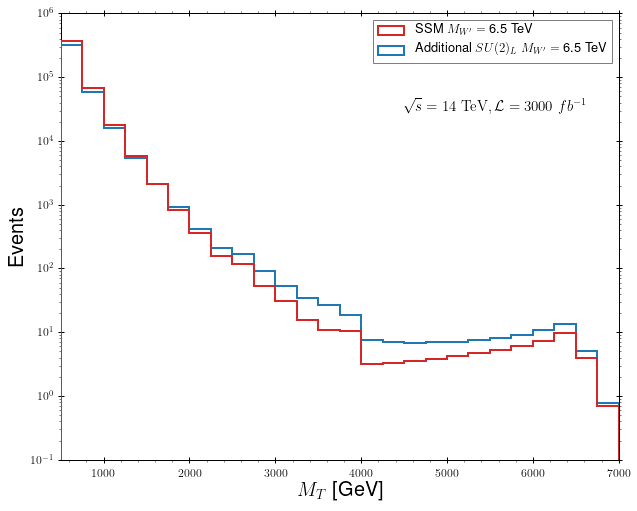

In [264]:
pyplot.rcParams['figure.figsize'] = (10.0, 8.0)
#fig.suptitle(r'No $y_{\ell \ell}$ Cut', fontsize=40)

BinNumber = 26
BinFirst  = 500.
BinLast   = 7000.

StepSize = (BinLast - BinFirst)/BinNumber
bins = []
bins.append(BinFirst)

for i in range(BinNumber): 
    BinFirst = BinFirst + StepSize
    bins.append(BinFirst)

binlabel = []
i=0
for i in range(len(bins)-1):
    binlabel.append((bins[i]+bins[i+1])/2.)


fig, ax1 = plt.subplots()
fig.set_facecolor('white')
#plt.title(r"$E_6 - \psi$ Model", fontsize=20)

#plt.hist(binlabel,bins=bins,
#             label=r'$W^+ \to \ell^+ \nu$ @LO', histtype="stepfilled", rwidth=1.0,
#             weights=NumofEvents_LepPos_SM, facecolor="orange",
#             color=None, edgecolor='orange', linewidth=2, linestyle="solid",
#             bottom=None, cumulative=False, density=False, align="mid", orientation="vertical",zorder=2)
#plt.hist(binlabel,bins=bins,
#             label=r'$W^- \to \ell^- \nu$ @LO', histtype="stepfilled", rwidth=1.0,
#             weights=NumofEvents_LepNeg_SM, facecolor="purple",
#             color=None, edgecolor='purple', linewidth=2, linestyle="solid",
#             bottom=None, cumulative=False, density=False, align="mid", orientation="vertical",zorder=3)
#plt.hist(binlabel,bins=bins,
#             label=r'$W \to \ell \nu$ @LO', histtype="stepfilled", rwidth=1.0,
#             weights=NumofEvents_LepPos_SM+NumofEvents_LepNeg_SM, facecolor="darkgoldenrod",
#             color=None, edgecolor='darkgoldenrod', linewidth=2, linestyle="solid",
#             bottom=None, cumulative=False, density=False, align="mid", orientation="vertical",zorder=1)

plt.hist(binlabel,bins=bins,
             label=r'SSM $M_{W^\prime}=$ 6.5 TeV', histtype="step", rwidth=1.0,
             weights=NumofEvents_LepPos_SSM+NumofEvents_LepNeg_SSM, facecolor="tab:red",
             color=None, edgecolor='tab:red', linewidth=2, linestyle="solid",
             bottom=None, cumulative=False, density=False, align="mid", orientation="vertical",zorder=5)

plt.hist(binlabel,bins=bins,
             label=r'Additional $SU(2)_L$ $M_{W^\prime}=$ 6.5 TeV', histtype="step", rwidth=1.0,
             weights=(NumofEvents_LepPos_AddSU2L+NumofEvents_LepNeg_AddSU2L), facecolor="tab:blue",
             color=None, edgecolor='tab:blue', linewidth=2, linestyle="solid",
             bottom=None, cumulative=False, density=False, align="mid", orientation="vertical",zorder=4)


plt.xlabel(r' $M_{T}$ [GeV] ', fontsize=20)
plt.ylabel('Events' , fontsize=20)
#plt.xscale('log')
plt.yscale('log')

ax1.text(4500, 3e4, r"$\displaystyle \sqrt{s} = 14 {\rm\ TeV}, \mathcal{L} = 3000\ fb^{-1}$", size=15)

leg = ax1.legend(loc='upper right',fontsize=13) #,ncol=2)#,framealpha=.5)#.get_lines().set_linewidth(0.)
leg.get_frame().set_alpha(0.5)
#leg.get_frame().set_linewidth(0.0)
leg.set_zorder(100)
ax1.set_xlim([min(bins),max(bins)])
ax1.set_ylim([1e-1,1e6])
ax1.tick_params(axis="x", direction="inout", length=6, width=1, color="black",zorder=100)
ax1.tick_params(axis="y", direction="inout", length=6, width=1, color="black",zorder=100)
ax1.tick_params(which="minor", axis="x", direction="out")
ax1.tick_params(which="minor", axis="y", direction="out")
fig.savefig('/Users/oozdal/Dropbox/WpZp_Project/Results/Ozer/EventsMT_14TeV.png')
plt.show()

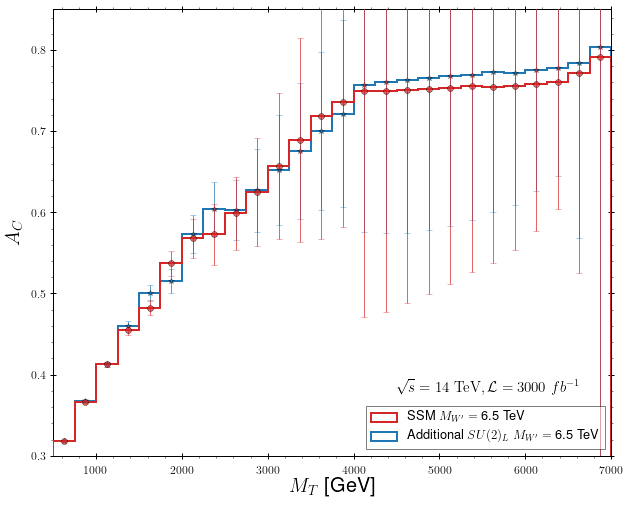

In [265]:
pyplot.rcParams['figure.figsize'] = (10.0, 8.0)
#fig.suptitle(r'No $y_{\ell \ell}$ Cut', fontsize=40)

BinNumber = 26
BinFirst  = 500.
BinLast   = 7000.

StepSize = (BinLast - BinFirst)/BinNumber
bins = []
bins.append(BinFirst)

for i in range(BinNumber): 
    BinFirst = BinFirst + StepSize
    bins.append(BinFirst)

binlabel = []
i=0
for i in range(len(bins)-1):
    binlabel.append((bins[i]+bins[i+1])/2.)


fig, ax1 = plt.subplots()
fig.set_facecolor('white')
#plt.title(r"$E_6 - \eta$ Model", fontsize=20)

#plt.hist(binlabel,bins=bins,
#             label=r'SM', histtype="step", rwidth=1.0,
#             weights=AC_SM, facecolor="black",
#             color=None, edgecolor='black', linewidth=2, linestyle="dashed",
#             bottom=None, cumulative=False, density=False, align="mid", orientation="vertical",zorder=1)

plt.hist(binlabel,bins=bins,
             label=r'SSM $M_{W^\prime}=$ 6.5 TeV', histtype="step", rwidth=1.0,
             weights=AC_SSM, facecolor="tab:red",
             color=None, edgecolor='tab:red', linewidth=2, linestyle="solid",
             bottom=None, cumulative=False, density=False, align="mid", orientation="vertical",zorder=3)

plt.hist(binlabel,bins=bins,
             label=r'Additional $SU(2)_L$ $M_{W^\prime}=$ 6.5 TeV', histtype="step", rwidth=1.0,
             weights=AC_AddSU2L, facecolor="tab:blue",
             color=None, edgecolor='tab:blue', linewidth=2, linestyle="solid",
             bottom=None, cumulative=False, density=False, align="mid", orientation="vertical",zorder=2)

ax1.errorbar(binlabel, AC_SSM, yerr=AC_SSM*unc(AC_SSM,(NumofEvents_LepPos_SSM+NumofEvents_LepNeg_SSM)), 
             linestyle='None', marker='o', color='tab:red', zorder = 6, alpha=0.7)

ax1.errorbar(binlabel, AC_AddSU2L, yerr=AC_AddSU2L*unc(AC_AddSU2L,(NumofEvents_LepPos_AddSU2L+NumofEvents_LepNeg_AddSU2L)), 
             linestyle='None', marker='*', color='tab:blue', zorder = 5, alpha=0.7)

plt.xlabel(r' $M_{T}$ [GeV]' , fontsize=20)
plt.ylabel(r'$A_{C}$' , fontsize=20)
#plt.xscale('log')
#plt.yscale('log')

ax1.text(4500, 0.38, r"$\displaystyle \sqrt{s} = 14 {\rm\ TeV}, \mathcal{L} = 3000\ fb^{-1}$", size=15)

leg = ax1.legend(loc='lower right',fontsize=13) #,ncol=2)#,framealpha=.5)#.get_lines().set_linewidth(0.)
leg.get_frame().set_alpha(0.5)
#leg.get_frame().set_linewidth(0.0)
leg.set_zorder(100)
ax1.set_xlim([min(bins),max(bins)])
ax1.set_ylim([0.3,0.85])
ax1.tick_params(axis="x", direction="inout", length=6, width=1, color="black",zorder=100)
ax1.tick_params(axis="y", direction="inout", length=6, width=1, color="black",zorder=100)
ax1.tick_params(which="minor", axis="x", direction="out")
ax1.tick_params(which="minor", axis="y", direction="out")

fig.savefig('/Users/oozdal/Dropbox/WpZp_Project/Results/Ozer/ACvsMT_14TeV.png') # dpi = 300 # save the figure to file
plt.show()